# 06 - Comparação de Métodos de Clusterização: Ward vs DBSCAN vs HDBSCAN

Neste notebook comparamos diferentes métodos de clusterização aplicados à climatologia da precipitação:
- **Ward (hierárquico)**: método clássico baseado em variância.

- **DBSCAN**: clusterização baseada em densidade.

- **HDBSCAN**: versão hierárquica do DBSCAN, com detecção de densidades variáveis.

O objetivo é verificar se métodos robustos a distribuições não normais (como precipitação) produzem regiões homogêneas significativamente diferentes do Ward.


In [3]:
pip install hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 78.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.40-cp313-cp313-linux_x86_64.whl size=852404 sha256=d35a31def3a58be1199860683352931e75741fe245400508d6a31f463f67b00d
  Stored in directory: /home/choluck/.cache/pip/wheels/c3/72/af/f4d00f372c844119d65a75541288c9a23c23696de08a71b7ec
Successfully built hdbscan
Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, DBSCAN
import hdbscan
import geopandas as gpd

In [9]:
# Carregar climatologia anual e sazonal
climatologia_anual = xr.open_dataarray('dataset/netcdf_data/climatologia_anual.nc')  # já calculada no notebook 05
climatologia_sazonal = xr.open_dataarray('dataset/netcdf_data/climatologia_sazonal.nc')  # DJF, MAM, JJA, SON
slope_freq_epi = xr.open_dataarray('dataset/netcdf_data/tendencia/slope_freq_epi_anual.nc')  # tendência (opcional)

# Máscara de pixels válidos
mask_valida = (~np.isnan(climatologia_anual.values)) & (climatologia_anual.values > 0)


In [92]:
# --- Carregar shapefile ---
shapefile_path = "dataset/shape/caatinga_estados.shp"
gdf_estados = gpd.read_file(shapefile_path)

def plot_clusters_comparacao(labels_map, titulo):
    cores = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"] #, "#8c564b"
    cmap_categorico = mcolors.ListedColormap(cores)
    plt.figure(figsize=(6,5))
    plt.imshow(labels_map, origin="upper",
               extent=[climatologia_anual.lon.min(), climatologia_anual.lon.max(),
                       climatologia_anual.lat.min(), climatologia_anual.lat.max()],
               cmap=cmap_categorico)
    gdf_estados.boundary.plot(ax=plt.gca(), color='black', linewidth=0.5)
    plt.colorbar(ticks=np.arange(1, len(cores) + 1), label='Rótulos de Cluster')
    
    plt.title(titulo)
    plt.show()

In [10]:
features = np.stack([
    climatologia_anual.values.flatten(),
    climatologia_sazonal.sel(season="DJF").values.flatten(),
    climatologia_sazonal.sel(season="MAM").values.flatten(),
    climatologia_sazonal.sel(season="JJA").values.flatten(),
    climatologia_sazonal.sel(season="SON").values.flatten(),
    slope_freq_epi.values.flatten()
], axis=1)

features_valid = features[mask_valida.flatten()]

# Normalizar
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_valid)


In [11]:
ward = AgglomerativeClustering(n_clusters=5, linkage='ward')
labels_ward = np.full(mask_valida.shape, np.nan)
labels_ward[mask_valida] = ward.fit_predict(features_scaled) + 1  # clusters 1–5


In [ ]:
# Parâmetros podem precisar de ajuste (eps e min_samples)
dbscan = DBSCAN(eps=0.1, min_samples=10)
labels_dbscan = np.full(mask_valida.shape, np.nan)
labels_dbscan[mask_valida] = dbscan.fit_predict(features_scaled) + 1 #-1 vira 0 (ruído)

/home/choluck/anaconda3/envs/cdo/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/choluck/anaconda3/envs/cdo/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


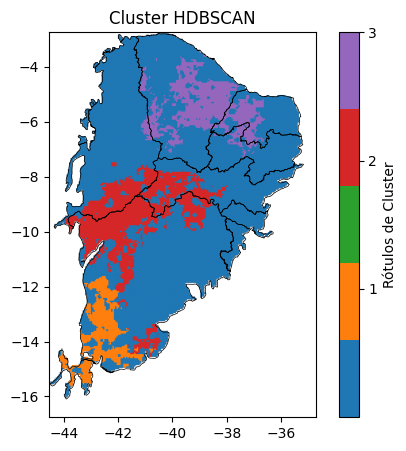

In [106]:
hdb = hdbscan.HDBSCAN(min_cluster_size=500, min_samples=140)
labels_hdb = np.full(mask_valida.shape, np.nan)
labels_hdb[mask_valida] = hdb.fit_predict(features_scaled) + 1  # -1 vira 0 (ruído)

plot_clusters_comparacao(labels_hdb, "Cluster HDBSCAN")


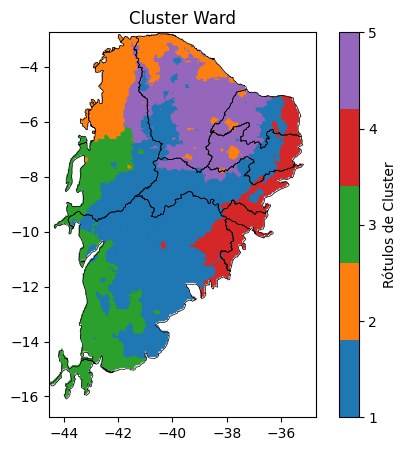

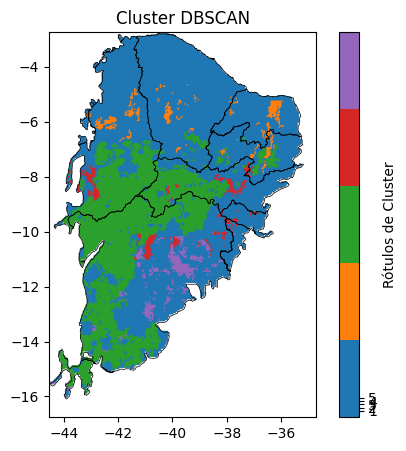

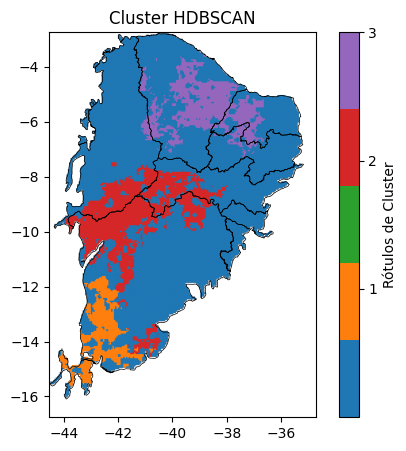

In [107]:
# Plotar os três métodos
plot_clusters_comparacao(labels_ward, "Cluster Ward")
plot_clusters_comparacao(labels_dbscan, "Cluster DBSCAN")
plot_clusters_comparacao(labels_hdb, "Cluster HDBSCAN")
